In [0]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [3]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (200, 200, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

# Expected Output is extremely large, but should end with:

#batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
#__________________________________________________________________________________________________
#activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0] 
#__________________________________________________________________________________________________
#mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
#                                                                 activation_276[0][0]             
#__________________________________________________________________________________________________
#concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
#                                                                 activation_280[0][0]             
#__________________________________________________________________________________________________
#activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0] 
#__________________________________________________________________________________________________
#mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
#                                                                 mixed9_1[0][0]                   
#                                                                 concatenate_5[0][0]              
#                                                                 activation_281[0][0]             
#==================================================================================================
#Total params: 21,802,784
#Trainable params: 0
#Non-trainable params: 21,802,784

--2020-03-15 00:27:20--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 2607:f8b0:4001:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   156MB/s    in 0.5s    

2020-03-15 00:27:21 (156 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in

In [39]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 10, 10, 768)


In [60]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)      
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)  
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)           
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile('adam', loss = 'binary_crossentropy', 
              metrics = ['acc'])

model.summary()

# Expected output will be large. Last few lines should be:

# mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_248[0][0]             
#                                                                  activation_251[0][0]             
#                                                                  activation_256[0][0]             
#                                                                  activation_257[0][0]             
# __________________________________________________________________________________________________
# flatten_4 (Flatten)             (None, 37632)        0           mixed7[0][0]                     
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 1024)         38536192    flatten_4[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 1024)         0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 1)            1025        dropout_4[0][0]                  
# ==================================================================================================
# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [6]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2020-03-15 00:29:42--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 2607:f8b0:4001:c14::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   170MB/s    in 0.8s    

2020-03-15 00:29:42 (170 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-03-15 00:29:44--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 2607:f8b0:4001:c14::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip

In [41]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses') # Directory with our training horse pictures
train_humans_dir = os.path.join(train_dir, 'humans') # Directory with our training humans pictures
validation_horses_dir = os.path.join(validation_dir, 'horses') # Directory with our validation horse pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')# Directory with our validation humanas pictures

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

# Expected Output:
# 500
# 527
# 128
# 128

500
527
128
128


In [61]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 32,
                                                    class_mode = 'binary', 
                                                    target_size = (200, 200))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                          class_mode  = 'binary', 
                                                          target_size = (200, 200))

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [62]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take less than 100 epochs)
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>=0.995) and (logs.get('val_acc')>=0.99):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()
history = model.fit_generator(train_generator,
            validation_data = validation_generator,
            steps_per_epoch =100,
            epochs = 100,
            callbacks=[callbacks],
            verbose = 2)

Epoch 1/100
Epoch 1/100
100/100 - 52s - loss: 0.3426 - acc: 0.9229 - val_loss: 0.0283 - val_acc: 0.9922
Epoch 2/100
Epoch 1/100
100/100 - 47s - loss: 0.0741 - acc: 0.9820 - val_loss: 0.0479 - val_acc: 0.9922
Epoch 3/100
Epoch 1/100
100/100 - 48s - loss: 0.0547 - acc: 0.9865 - val_loss: 0.0195 - val_acc: 0.9961
Epoch 4/100
Epoch 1/100
100/100 - 48s - loss: 0.0712 - acc: 0.9839 - val_loss: 0.0620 - val_acc: 0.9883
Epoch 5/100
Epoch 1/100
100/100 - 48s - loss: 0.0434 - acc: 0.9891 - val_loss: 0.0106 - val_acc: 0.9961
Epoch 6/100
Epoch 1/100
100/100 - 48s - loss: 0.0249 - acc: 0.9926 - val_loss: 0.0774 - val_acc: 0.9883
Epoch 7/100
Epoch 1/100
100/100 - 49s - loss: 0.0352 - acc: 0.9926 - val_loss: 0.2040 - val_acc: 0.9609
Epoch 8/100
Epoch 1/100
100/100 - 48s - loss: 0.0235 - acc: 0.9942 - val_loss: 0.0124 - val_acc: 0.9961
Epoch 9/100
Epoch 1/100
100/100 - 49s - loss: 0.0166 - acc: 0.9939 - val_loss: 0.0334 - val_acc: 0.9922
Epoch 10/100
Epoch 1/100

Reached 99.9% accuracy so cancelling t

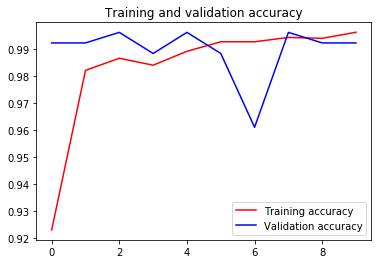

<Figure size 432x288 with 0 Axes>

In [63]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

### Testing with random images

In [64]:
from google.colab import files


uploaded = files.upload()

Saving horse1.jpg to horse1 (5).jpg
Saving horse2.jpg to horse2 (5).jpg
Saving horses-in-field.jpg to horses-in-field (7).jpg
Saving human1.jfif to human1 (5).jfif
Saving human2.jfif to human2 (5).jfif
Saving human3.jfif to human3 (5).jfif
Saving humanmix.jfif to humanmix (5).jfif
Saving humanschildren.jfif to humanschildren (5).jfif
Saving Irish-Cob-horses-autumn-pasture.jpg to Irish-Cob-horses-autumn-pasture (5).jpg


In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image

[[3.9627744e-07]]
[[8.314065e-05]]
[[4.5098528e-07]]
[[0.9927827]]
[[0.9999286]]
[[0.9999999]]
[[0.99999475]]
[[1.]]
[[0.]]


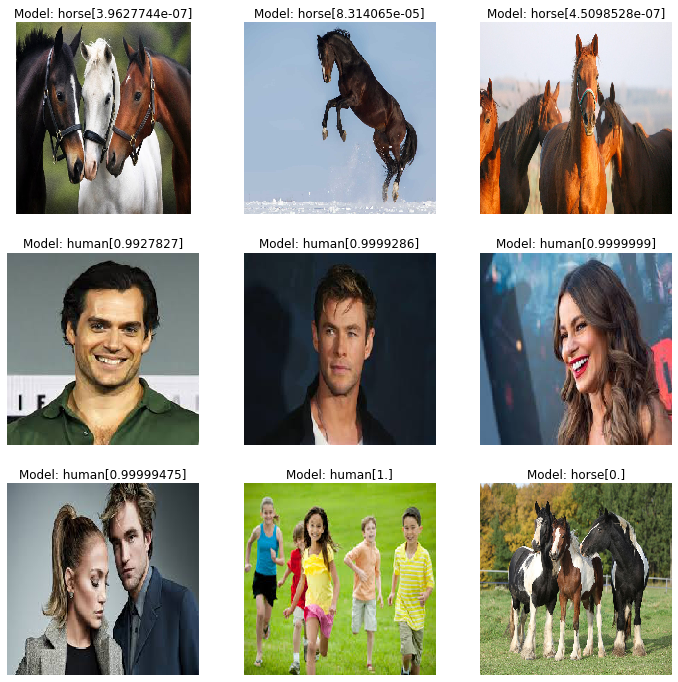

In [65]:
# Set up matplotlib fig, and size it to fit 4x4 pics
ncols = 3
nrows = 3

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i, img_path in enumerate(uploaded.keys()):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  path = "/content/" + img_path
  img = image.load_img(path, target_size=(200, 200))
  x = image.img_to_array(img)/ 255.
  #print("Before",x.shape)
  x = np.expand_dims(x, axis=0)
  #print("After",x.shape)

  images = np.vstack([x])
  #print("BeforePrediction",images.shape)
  classes = model.predict(images)
  print(classes)
  if classes[0]>0.5:
     plt.title('Model: human'+ str(classes[0])) 
  else:
     plt.title('Model: horse' + str(classes[0])) 
  plt.imshow(img)
  img.close()


plt.show()